## Variational autoencoder (VAE)

Variational autoencoders are a slightly more modern and interesting take on autoencoding.

<p align='center'>
  <img src='https://miro.medium.com/max/1400/0*ndg6glTk5l_ouLON.png' width=700></img>
</p>

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model) for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

Because a VAE is a more complex example, we have made the code available on [Github](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py) as a standalone script. Here we will review step by step how the model is created.

### Loss

The loss function of the VAE is defined by two terms, the reconstruction loss and the regularizer which is essentially a KL divergence between the encoder’s distribution and the latent space.

$$\mathcal{L}(\theta, \phi) = -\mathbb{E}_{X \sim q_{\theta}}[P_{\theta}(x|z)] + \mathcal{D}_\text{KL}(q_{\phi}(z|x) || p_{\theta}(z)) $$

where the KL divergence is defined below

$$\mathcal{D}_\text{KL}(P||Q) = \sum_x P(x) \log(\frac{P(x)}{Q(x)})$$


### KL divergence

What does KL divergence mean?

<p align='center'>
  <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Kullback%E2%80%93Leibler_distributions_example_1.svg/600px-Kullback%E2%80%93Leibler_distributions_example_1.svg.png' width=600></img>
</p>

Solution for $\mathcal{D}(P||Q)$ is below

<p align='center'>
  <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/40cf6731eed13322031049e156e9e7aebb3ae340' width=600></img>
</p>

and for $\mathcal{D}(Q||P)$ is below

<p align='center'><img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/7c6f1afcdb28ae9d477e2539c2490784fe89ec36' width=600></img></p>



In [15]:
# import
import keras
from keras import layers

In [16]:
# input
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [25]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.00001)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Finally, we can map these sampled latent points back to reconstructed inputs:

In [26]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [33]:
# summary
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          50500       ['input_3[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          51152       ['encoder[0][2]']                
                                                                                            

What we've done so far allows us to instantiate 3 models:

- an end-to-end autoencoder mapping inputs to reconstructions
- an encoder mapping inputs to the latent space
- a generator that can take points on the latent space and will output the corresponding reconstructed samples.


We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [27]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

We train our VAE on MNIST digits:

In [28]:
from keras.datasets import mnist
import numpy as np

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 188.5094 - val_loss: 168.4880
Epoch 2/100
1875/1875 [==============================] - 10s 5ms/step - loss: 165.7443 - val_loss: 162.4903
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 160.8530 - val_loss: 159.2367
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 157.5824 - val_loss: 156.4051
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 155.4839 - val_loss: 154.7016
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 154.1239 - val_loss: 153.7073
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 153.0794 - val_loss: 153.4391
Epoch 8/100
1875/1875 [==============================] - 8s 4ms/step - loss: 152.2299 - val_loss: 152.1881
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 151.5184 - val_loss: 151.5402
Epoch 10/100
1875/1875 [===========

In [30]:
# prediction
pred_ = vae.predict(x_test)

In [31]:
# import 
import matplotlib.pyplot as plt

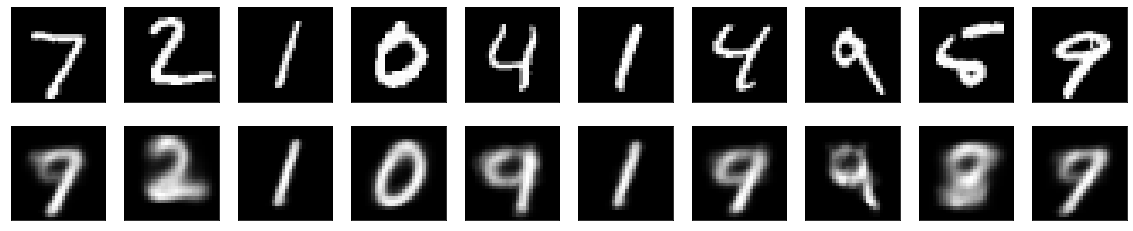

In [32]:
# Use Matplotlib (don't ask)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pred_[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Investigation ends here.